In [1]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
%matplotlib inline
%load_ext autoreload
%autoreload 2
import random
import pdb
# from multiprocessing import Process, Manager
# from multiprocessing import set_start_method

In [2]:
import sys
sys.path.insert(0, '/home/nkotelevskii/github/corrected_l2hmc/l2hmc_pytorch/l2hmc/utils/')

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = "cpu"
device

'cpu'

In [4]:
from func_utils_pt import acl_spectrum, ESS

In [5]:
from distributions_pt import Gaussian
from layers_pt import Net
from dynamics_pt import Dynamics
from sampler_pt import propose
from notebook_utils_pt import get_hmc_samples

In [6]:
network = Net

In [7]:
x_dim = 2
mu = np.zeros(2,)
mu = torch.tensor(mu).to(device)
cov = np.array([[50.05, -49.95], [-49.95, 50.05]])
cov = torch.tensor(cov).to(device)

distribution = Gaussian(mu, cov, device=device)
dynamics = Dynamics(x_dim, distribution.get_energy_function(), T=10, eps=0.1, net_factory=network, device=device)

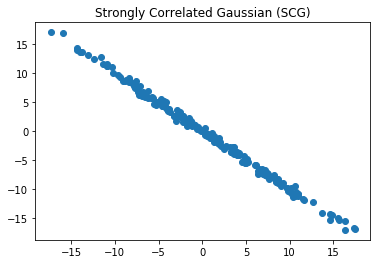

In [8]:
S = distribution.get_samples(200)
plt.title('Strongly Correlated Gaussian (SCG)')
plt.scatter(S[:, 0], S[:, 1])
plt.show()

In [9]:
n_steps = 5000
n_samples = 200
scale = torch.tensor(0.1, device=device)

In [10]:
optim = Adam(dynamics.parameters())

In [11]:
# [p for p in dynamics.parameters()]

In [12]:
dynamics.alpha

Parameter containing:
tensor(0.1000, requires_grad=True)

In [13]:
scheduler = StepLR(optim, step_size=1000, gamma=0.96)

def criterion(v1, v2):
    return scale * (torch.mean(1.0 / v1) + torch.mean(1.0 / v2)) + (-torch.mean(v1) - torch.mean(v2)) / scale

for t in tqdm(range(n_steps)):    
    if(t==0):
        x = torch.randn(n_samples, x_dim, dtype=torch.float32, device=device)
    else:
        x = output[0]

    z = torch.randn_like(x, dtype=torch.float32, device=device)

    optim.zero_grad()
    Lx, _, px, output = propose(x, dynamics, do_mh_step=True, device=device)
    Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False, device=device)

    v1 = (torch.sum((x - Lx)**2, dim=1) * px) + torch.tensor(1e-4, dtype=torch.float32, device=device)
    v2 = (torch.sum((z - Lz)**2, dim=1) * pz) + torch.tensor(1e-4, dtype=torch.float32, device=device)
    scale = torch.tensor(0.1, dtype=torch.float32, device=device)

    loss = criterion(v1, v2)
    loss.backward()

    optim.step()
#     pdb.set_trace()

    if t % 100 == 0:
        current_lr = None
        for param_group in optim.param_groups:
            current_lr = param_group['lr']
        print ('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss.item(), np.mean(px.cpu().detach().numpy()), current_lr))
    scheduler.step()
    optim.zero_grad()

  0%|          | 1/5000 [00:00<15:14,  5.47it/s]

Step: 0 / 5000, Loss: 1.25e+03, Acceptance sample: 0.09, LR: 0.00100


  2%|▏         | 102/5000 [00:20<16:12,  5.04it/s]

Step: 100 / 5000, Loss: -1.56e+02, Acceptance sample: 0.49, LR: 0.00100


  4%|▍         | 201/5000 [00:39<16:04,  4.98it/s]

Step: 200 / 5000, Loss: -1.41e+03, Acceptance sample: 0.33, LR: 0.00100


  6%|▌         | 302/5000 [00:59<15:25,  5.08it/s]

Step: 300 / 5000, Loss: -2.81e+03, Acceptance sample: 0.30, LR: 0.00100


  8%|▊         | 401/5000 [01:19<15:08,  5.06it/s]

Step: 400 / 5000, Loss: -4.33e+03, Acceptance sample: 0.32, LR: 0.00100


 10%|█         | 502/5000 [01:39<14:50,  5.05it/s]

Step: 500 / 5000, Loss: -5.66e+03, Acceptance sample: 0.31, LR: 0.00100


 12%|█▏        | 602/5000 [01:59<14:17,  5.13it/s]

Step: 600 / 5000, Loss: -6.01e+03, Acceptance sample: 0.29, LR: 0.00100


 14%|█▍        | 701/5000 [02:19<14:32,  4.93it/s]

Step: 700 / 5000, Loss: -5.81e+03, Acceptance sample: 0.30, LR: 0.00100


 16%|█▌        | 802/5000 [02:39<14:00,  4.99it/s]

Step: 800 / 5000, Loss: -7.41e+03, Acceptance sample: 0.42, LR: 0.00100


 18%|█▊        | 902/5000 [02:59<13:33,  5.04it/s]

Step: 900 / 5000, Loss: -8.41e+03, Acceptance sample: 0.39, LR: 0.00100


 20%|██        | 1002/5000 [03:19<13:19,  5.00it/s]

Step: 1000 / 5000, Loss: -7.79e+03, Acceptance sample: 0.41, LR: 0.00096


 22%|██▏       | 1102/5000 [03:39<13:03,  4.98it/s]

Step: 1100 / 5000, Loss: -7.35e+03, Acceptance sample: 0.33, LR: 0.00096


 24%|██▍       | 1201/5000 [03:59<12:48,  4.94it/s]

Step: 1200 / 5000, Loss: -7.51e+03, Acceptance sample: 0.35, LR: 0.00096


 26%|██▌       | 1301/5000 [04:19<12:21,  4.99it/s]

Step: 1300 / 5000, Loss: -8.38e+03, Acceptance sample: 0.42, LR: 0.00096


 28%|██▊       | 1402/5000 [04:39<11:46,  5.09it/s]

Step: 1400 / 5000, Loss: -6.86e+03, Acceptance sample: 0.43, LR: 0.00096


 30%|███       | 1501/5000 [04:59<11:47,  4.95it/s]

Step: 1500 / 5000, Loss: -7.70e+03, Acceptance sample: 0.34, LR: 0.00096


 32%|███▏      | 1601/5000 [05:19<11:23,  4.97it/s]

Step: 1600 / 5000, Loss: -6.99e+03, Acceptance sample: 0.39, LR: 0.00096


 34%|███▍      | 1701/5000 [05:38<11:02,  4.98it/s]

Step: 1700 / 5000, Loss: -8.07e+03, Acceptance sample: 0.38, LR: 0.00096


 36%|███▌      | 1802/5000 [05:59<10:17,  5.18it/s]

Step: 1800 / 5000, Loss: -8.16e+03, Acceptance sample: 0.42, LR: 0.00096


 38%|███▊      | 1901/5000 [06:18<10:23,  4.97it/s]

Step: 1900 / 5000, Loss: -7.85e+03, Acceptance sample: 0.40, LR: 0.00096


 40%|████      | 2001/5000 [06:39<10:06,  4.95it/s]

Step: 2000 / 5000, Loss: -9.35e+03, Acceptance sample: 0.42, LR: 0.00092


 42%|████▏     | 2101/5000 [06:58<09:30,  5.08it/s]

Step: 2100 / 5000, Loss: -7.76e+03, Acceptance sample: 0.38, LR: 0.00092


 44%|████▍     | 2202/5000 [07:19<09:08,  5.10it/s]

Step: 2200 / 5000, Loss: -9.64e+03, Acceptance sample: 0.40, LR: 0.00092


 46%|████▌     | 2302/5000 [07:38<09:01,  4.98it/s]

Step: 2300 / 5000, Loss: -7.69e+03, Acceptance sample: 0.39, LR: 0.00092


 48%|████▊     | 2402/5000 [07:58<08:35,  5.04it/s]

Step: 2400 / 5000, Loss: -7.17e+03, Acceptance sample: 0.40, LR: 0.00092


 50%|█████     | 2501/5000 [08:18<08:16,  5.03it/s]

Step: 2500 / 5000, Loss: -9.39e+03, Acceptance sample: 0.43, LR: 0.00092


 52%|█████▏    | 2601/5000 [08:38<07:58,  5.01it/s]

Step: 2600 / 5000, Loss: -8.16e+03, Acceptance sample: 0.43, LR: 0.00092


 54%|█████▍    | 2702/5000 [08:58<07:31,  5.09it/s]

Step: 2700 / 5000, Loss: -8.47e+03, Acceptance sample: 0.35, LR: 0.00092


 56%|█████▌    | 2795/5000 [09:17<07:18,  5.03it/s]

KeyboardInterrupt: 

In [14]:
dynamics.alpha

Parameter containing:
tensor(0.1620, requires_grad=True)

In [15]:
length_of_chains = 2000

In [16]:
samples = torch.tensor(distribution.get_samples(n=n_samples), dtype=torch.float32, device=device)
final_samples = []

samples_ = samples
with torch.no_grad():
    for t in tqdm(range(length_of_chains)):
        final_samples.append(samples_.cpu().numpy())
        _, _, _, samples_ = propose(samples_, dynamics, do_mh_step=True, trainable=False)
        samples_ = samples_[0].detach()

100%|██████████| 2000/2000 [01:01<00:00, 32.55it/s]


In [17]:
L2HMC_samples = np.array(final_samples)
with torch.no_grad():
    HMC_samples_1 = get_hmc_samples(2, 0.1, distribution.get_energy_function(), steps=length_of_chains, samples=samples)
    HMC_samples_2 = get_hmc_samples(2, 0.15, distribution.get_energy_function(), steps=length_of_chains, samples=samples)
    HMC_samples_3 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), steps=length_of_chains, samples=samples)

100%|██████████| 2000/2000 [00:18<00:00, 109.28it/s]


In [18]:
L2HMC_samples.shape

(2000, 200, 2)

In [19]:
HMC_samples_1.shape

(2000, 200, 2)

In [20]:
# from func_utils_pt import acl_spectrum, ESS

In [21]:
scale = np.sqrt(np.trace(cov.cpu().detach().numpy()))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

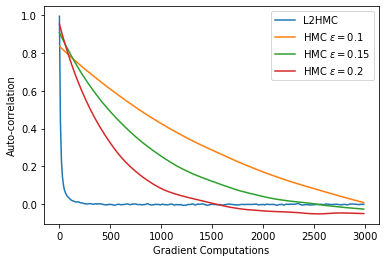

In [22]:
points_to_plot = np.min([300, length_of_chains - 1])
xaxis = 10 * np.arange(points_to_plot)
plt.plot(xaxis, L2HMC[:points_to_plot], label='L2HMC')
plt.plot(xaxis, HMC1[:points_to_plot], label='HMC $\epsilon=0.1$')
plt.plot(xaxis, HMC2[:points_to_plot], label='HMC $\epsilon=0.15$')
plt.plot(xaxis, HMC3[:points_to_plot], label='HMC $\epsilon=0.2$')
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient Computations')
plt.legend()
plt.show()

In [23]:
# print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

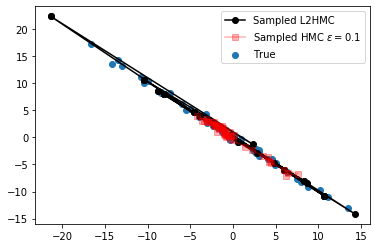

In [24]:
num = -4
points_to_plot = np.min([50, length_of_chains - 1])

plt.scatter(S[:points_to_plot, 0], S[:points_to_plot, 1], label='True')
plt.plot(L2HMC_samples[:points_to_plot, num, 0], L2HMC_samples[:points_to_plot, num, 1], label='Sampled L2HMC', color='black', marker='o')
plt.plot(HMC_samples_2[:points_to_plot, num, 0], HMC_samples_2[:points_to_plot, num, 1], label='Sampled HMC $\epsilon=0.1$', color='red', marker='s', alpha=0.3)
plt.legend()
plt.show()